In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

In [3]:
# defender.to_csv('defender_df.csv', index=False)

In [4]:
df = pd.read_csv('./data/defender_df.csv')
pd.set_option('display.max_columns', None)

In [5]:
# Drop columns
df = df.drop(['position', 'player', 'team', 'foot'], axis=1)

In [6]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)

In [7]:
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)

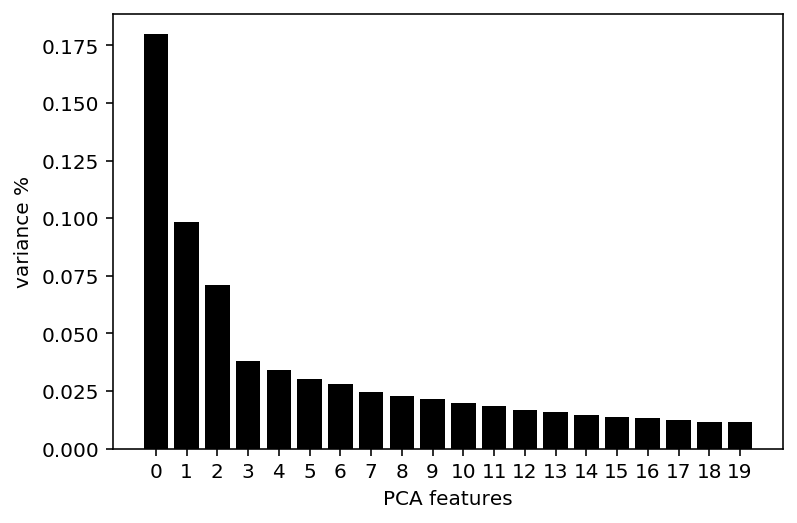

In [8]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features);

In [9]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

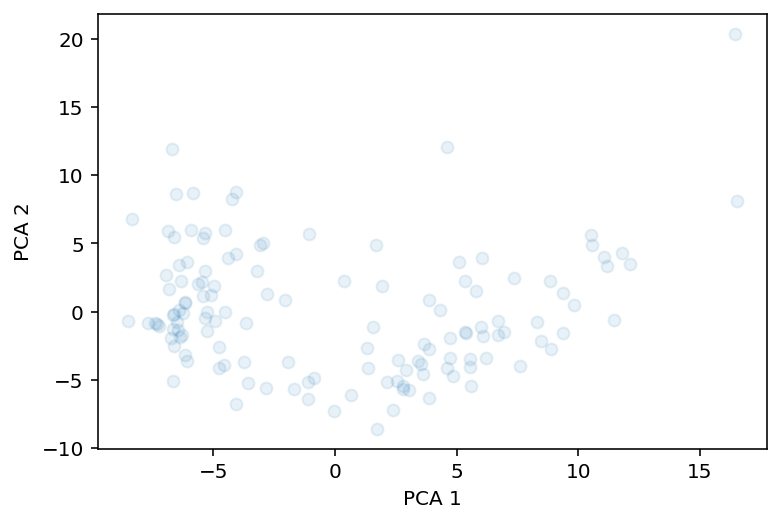

In [10]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2');

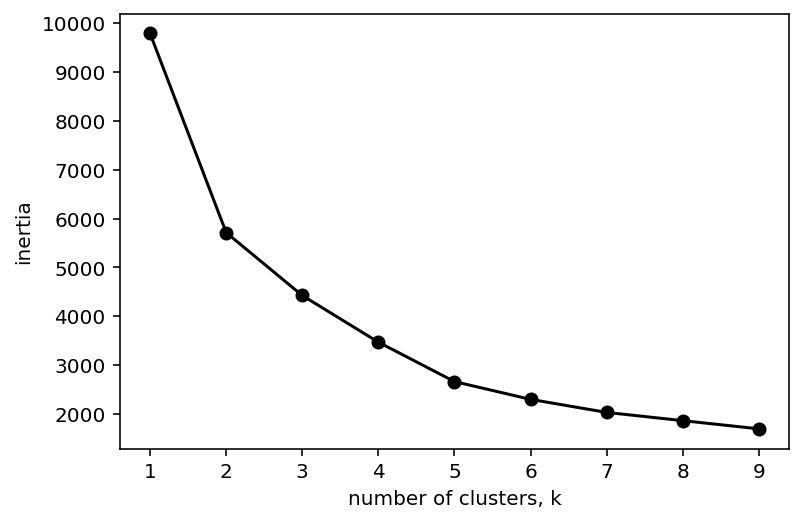

In [11]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [9]:
# Create a PCA instance: pca
pca = PCA(n_components=2)
skillsPCA = pca.fit_transform(X_std)

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
skillsPCA_labels = kmeans.fit_predict(skillsPCA)

In [20]:
dfskillsPCA = pd.DataFrame(skillsPCA)
dfskillsPCA['cluster'] = skillsPCA_labels

In [38]:
dfskillsPCA['cluster'] = skillsPCA_labels
dfskillsPCA.columns = ['x1','x2','cluster']

In [41]:
kmeans = KMeans(n_clusters=6)
clustering_ori = kmeans.fit_predict(dfskillsPCA)

In [42]:
dftsne2D = dftsne
dftsne2D['cluster'] = clustering_ori

In [44]:
X = dfskillsPCA
Xtsne = TSNE(n_components=2).fit_transform(X)
dftsneFull = pd.DataFrame(Xtsne)

In [45]:
dftsneFull['cluster'] = clustering_ori
dftsneFull.columns = ['x1','x2','cluster']

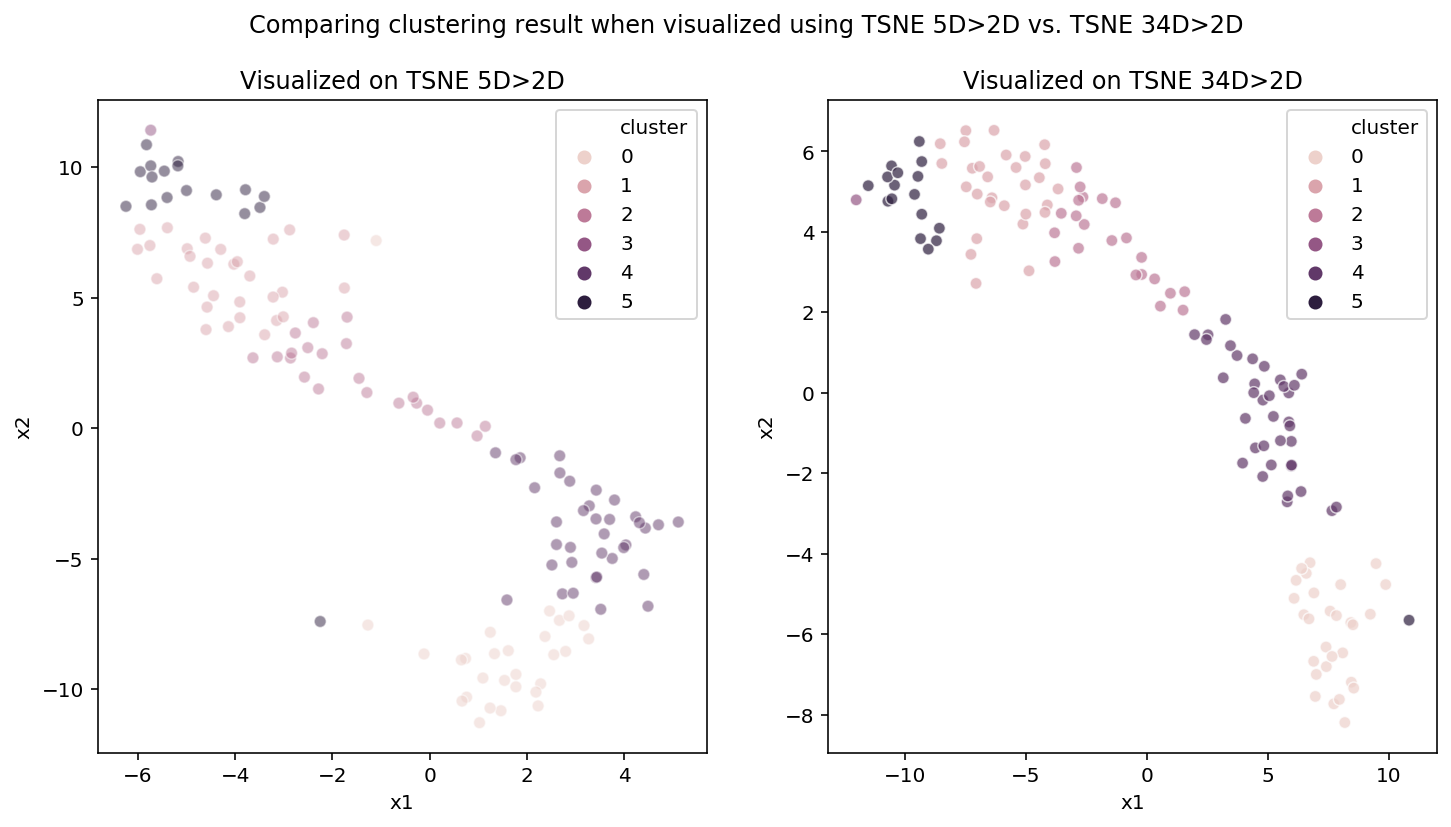

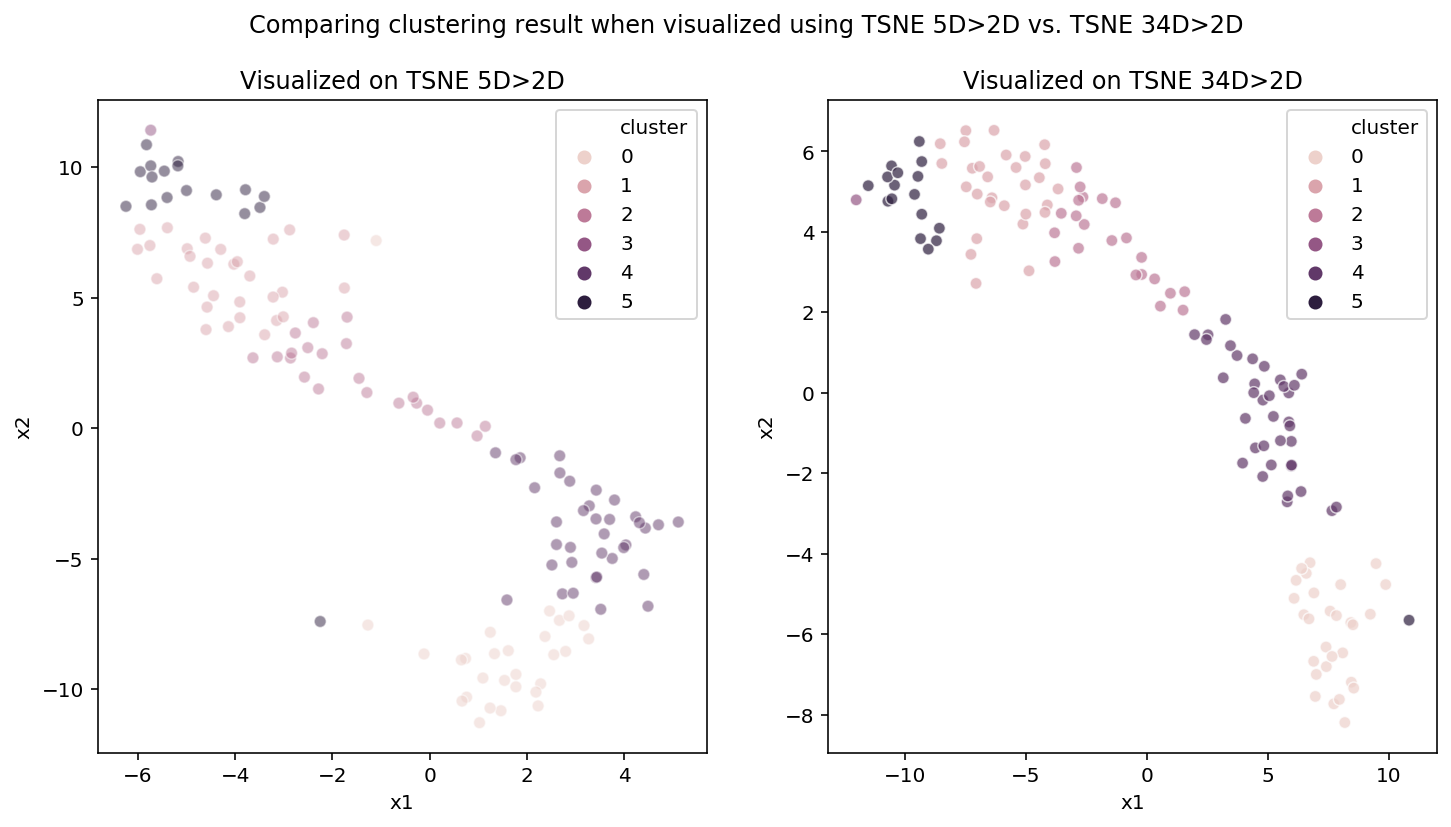

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=dftsne2D,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE 5D>2D')
sns.scatterplot(data=dftsneFull,x='x1',y='x2',hue='cluster',legend="full",alpha=0.7,ax=ax[1])
ax[1].set_title('Visualized on TSNE 34D>2D')
fig.suptitle('Comparing clustering result when visualized using TSNE 5D>2D vs. TSNE 34D>2D')
display(fig)

In [48]:
dfskillsPCA['cluster'] = clustering_ori

In [54]:
def outside_limit(df, label_col, label, sensitivity):
  feature_list = dfskillsPCA.columns[:-1]
  
  plot_list = []
  mean_overall_list = []
  mean_cluster_list = []
  
  for i,varname in enumerate(feature_list):
    
    #     get overall mean for a variable, set lower and upper limit
    mean_overall = df[varname].mean()
    lower_limit = mean_overall - (mean_overall*sensitivity)
    upper_limit = mean_overall + (mean_overall*sensitivity)

    #     get cluster mean for a variable
    cluster_filter = df[label_col]==label
    pd_cluster = df[cluster_filter]
    mean_cluster = pd_cluster[varname].mean()
    
    #     create filter to display graph with 0.5 deviation from the mean
    if mean_cluster <= lower_limit or mean_cluster >= upper_limit:
      plot_list.append(varname)
      mean_overall_std = mean_overall/mean_overall
      mean_cluster_std = mean_cluster/mean_overall
      mean_overall_list.append(mean_overall_std)
      mean_cluster_list.append(mean_cluster_std)
   
  mean_df = pd.DataFrame({'feature_list':plot_list,
                         'mean_overall_list':mean_overall_list,
                         'mean_cluster_list':mean_cluster_list})
  mean_df = mean_df.sort_values(by=['mean_cluster_list'], ascending=False)
  
  return mean_df

def plot_barchart_all_unique_features(df, label_col, label, ax, sensitivity):
  
  mean_df = outside_limit(df, label_col, label, sensitivity)
  mean_df_to_plot = mean_df.drop(['mean_overall_list'], axis=1)
  
  if len(mean_df.index) != 0:
    sns.barplot(y='feature_list', x='mean_cluster_list', data=mean_df_to_plot, palette=sns.cubehelix_palette(20, start=.5, rot=-.75, reverse=True), \
                alpha=0.75, dodge=True, ax=ax)

    for i,p in enumerate(ax.patches):
      ax.annotate("{:.02f}".format((p.get_width())), 
                  (1, p.get_y() + p.get_height() / 2.), xycoords=('axes fraction', 'data'),
                  ha='right', va='top', fontsize=10, color='black', rotation=0, 
                  xytext=(0, 0),
                  textcoords='offset pixels')
  
  ax.set_title('Unique Characteristics of Cluster ' + str(label))
  ax.set_xlabel('Standardized Mean')
  ax.axvline(x=1, color='k')

def plot_features_all_cluster(df, label_col, n_clusters, sensitivity):
  n_plot = n_clusters
  fig, ax = plt.subplots(n_plot, 1, figsize=(12, n_plot*6), sharex='col')
  ax= ax.ravel()
  
  label = np.arange(n_clusters)
  for i in label:
    plot_barchart_all_unique_features(df, label_col, label=i, ax=ax[i], sensitivity=sensitivity)
    ax[i].xaxis.set_tick_params(labelbottom=True)
    
  plt.tight_layout()
  display(fig)

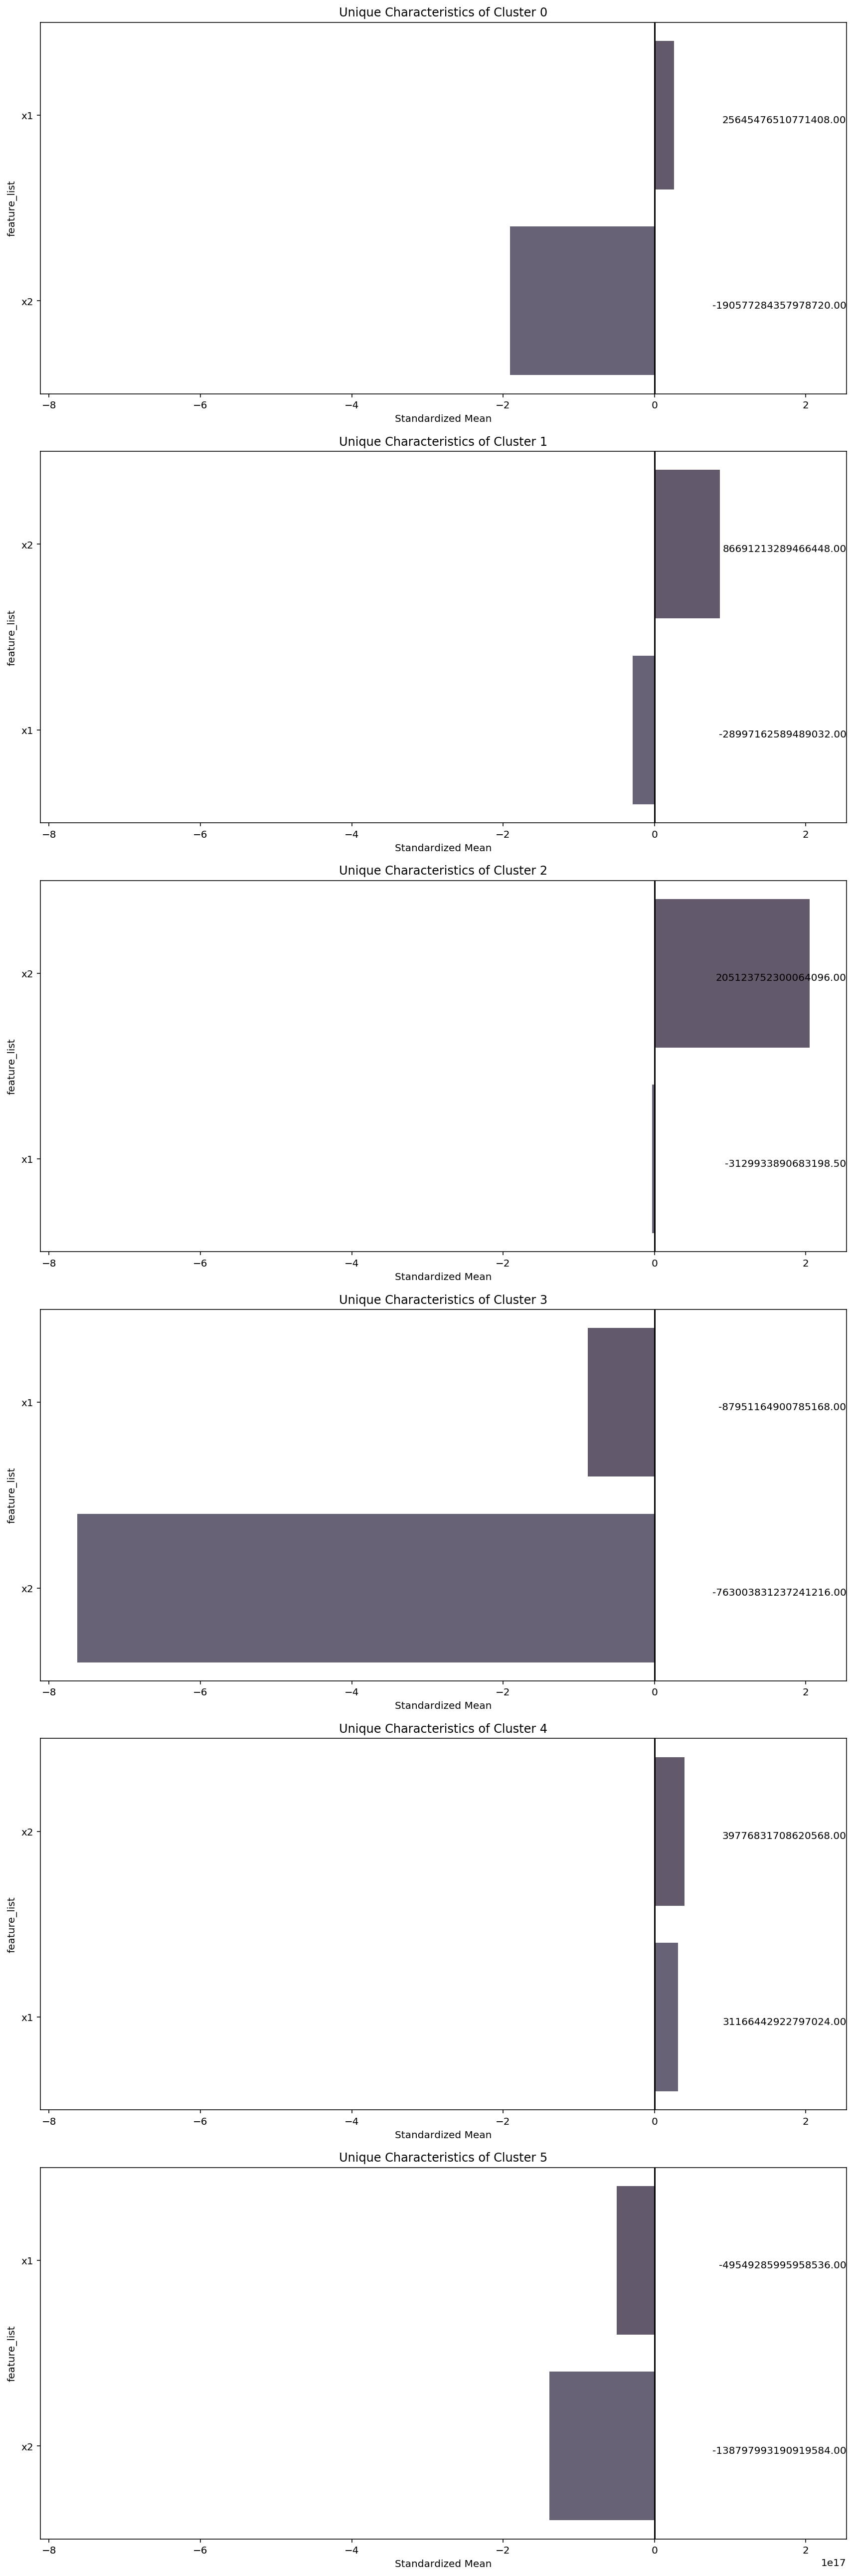

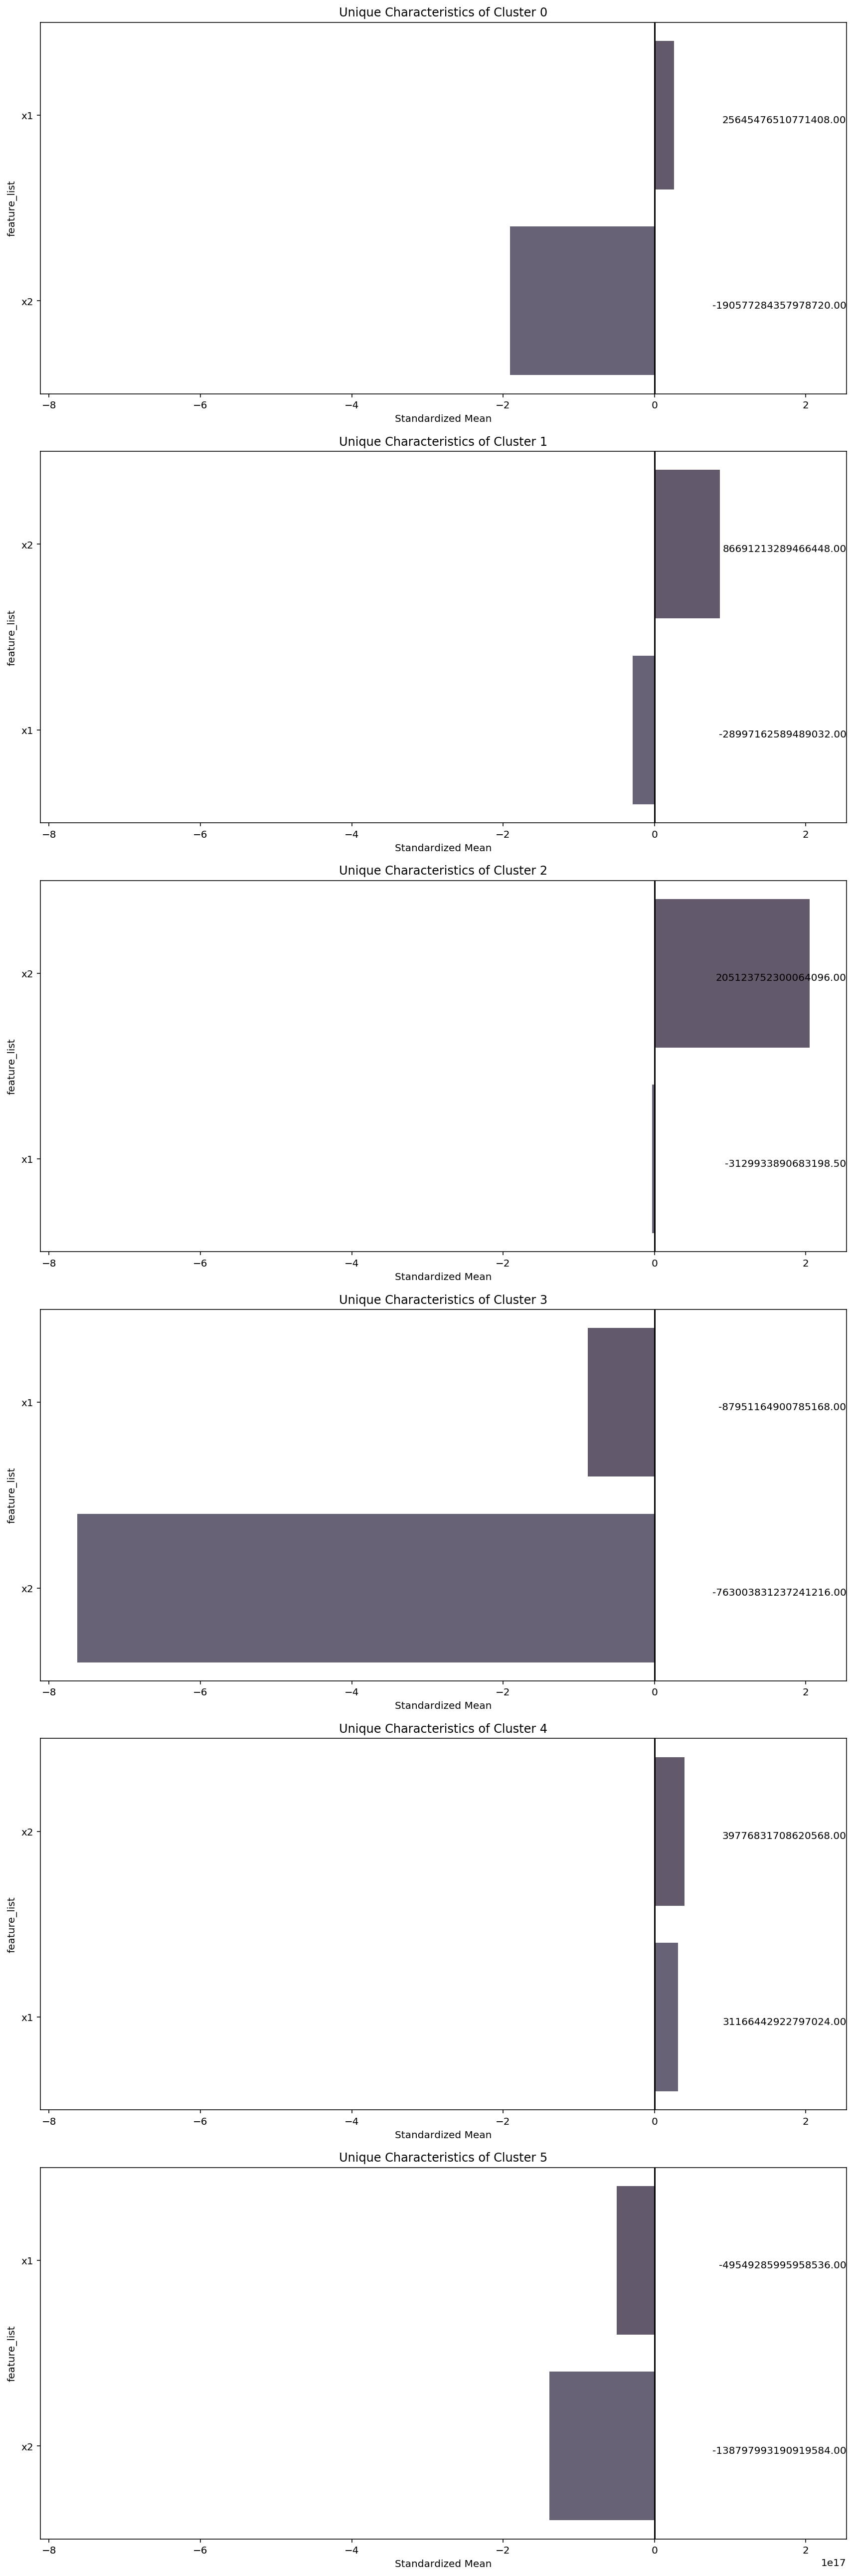

In [55]:
plot_features_all_cluster(df=dfskillsPCA, label_col='cluster', n_clusters=6, sensitivity=0.2)